## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

# 1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)

In [1]:
#### Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from tqdm import tqdm

# Настройки отображения графиков
%matplotlib inline
# Стили графиков 
sns.set_style("whitegrid")
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)



### Сбор данных и их подготовка 

In [2]:
df = pd.read_csv('ab_test_ensembles.csv')
df.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [3]:
# смотрим основную информацию о нашем DataFrame которая может показать в каких данных много пропусков и тип данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [4]:
# Убедимся, что контрольная группа и испытуемая видят разные работы сервиса
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [5]:
# проверяем уникальность пользователей
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [6]:
# используем всю выборку 200к+ записей для формирования
# control_sample = df[df['group'] == 'control']
# treatment_sample = df[df['group'] == 'treatment']

# Сформируем общую случайную выборку
# ab_df = pd.concat([control_sample, treatment_sample], axis=0)
# ab_df.reset_index(drop=True, inplace=True)
# ab_df.head()

In [7]:
# определяем долю уникальных значений относительно общего числа вхождений
df.group.value_counts(normalize=True)

group
treatment    0.500126
control      0.499874
Name: proportion, dtype: float64

### Визуализация результатов эксперимента 

In [8]:
# рассчитаем выборочные статистики, чтобы понять каково распределение данных и как выглядят наши выборки
conversion_rates = df.groupby('group')['converted']

# Стандартное отклонение для выборки
std_proportion = lambda x: np.std(x, ddof=0)

# Стандартная ошибка для выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

# уровень коверсии
conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя одинаково, за исключением выборочного среднего коэффициента конверсии ~11.89% против ~12.04%

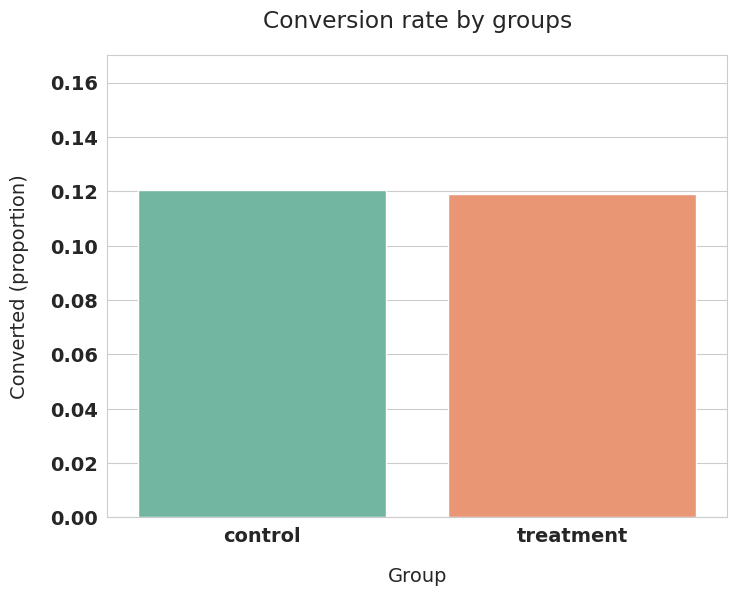

In [9]:
plt.rcParams['font.family'] = 'sans-serif'
# определим цвета.  сопоставим цвета с колонкой group в нашем df
unique_groups = df['group'].unique()
colors = sns.color_palette("Set2", n_colors=len(unique_groups))  # выберем палитру и сопоставим с unique_groups

plt.figure(figsize=(8, 6))
sns.barplot(x='group', y='converted', data=df, hue='group', errorbar=('ci', False), palette=colors, legend=False) 
plt.ylim(0, 0.17)
plt.title('Conversion rate by groups', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
plt.show()


### Тестирование гипотезы 

In [10]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


### Интерпретация результатов 

Так как наше p-значение = 0.216 что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, это означает, что новый вариант работы svm_ensemble_v_1_22 никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.

Доверительный интервал для испытуемой группы [0.117, 0.121] или 11% и 12% соответственно:

Он не включает наш baseline в 13%.
Он не достигает нашей цели 15%
Мы можем интерпретировать это как - наиболее вероятно, что реальный уровень конверсии нового варианта работы svm_ensemble_v_1_22  будет близок к baseline чем к 15%, который мы определили по нашей цели. 

Таким образом у нас есть выбор:
1. Так как мы будем близко к baseline то можно оставить вариант работы standart.
2. Можно создать новый вариант (потратить время, деньги, нервы) и опять протестировать, надо решать стоят ли затраты на новый вариант 2% улучшения (покроются ли затраты на работу).

Нам стоит оставить старый вариант работы.

# 2.Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

##### Проводим А/В тесты для двух групп отдельно:
1.registered user    
2. new user

## Тест группы new_user

In [11]:
# создадим df для группы new_user
df_new = df.loc[df['user_type'] == 'new_user']
df_new

,user_id,timestamp,group,variants,converted,location,age_group,user_type
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user
11,1cc7ebbb-efb9-43a6-9230-11161ae910ba,2022-05-21 22:37:47.774891,treatment,svm_ensemble_v_1_22,0,United Kingdom,58+,new_user
14,137d7bf0-309c-4aad-ad9e-302a2f45dc70,2022-05-22 11:45:11.327945,treatment,svm_ensemble_v_1_22,0,United Kingdom,50-57,new_user
...,...,...,...,...,...,...,...,...
294471,31b72c34-b5e6-412d-a651-2d68e40294b7,2022-05-21 22:44:20.378320,control,standard,0,United Kingdom,50-57,new_user
294472,28897e32-65de-4fd0-8b57-66f1dc1cab3f,2022-05-04 03:36:46.071379,treatment,svm_ensemble_v_1_22,0,United Kingdom,18-25,new_user
294473,497bf0f8-0092-4736-8ae7-775b6cc9736c,2022-05-03 22:28:38.630509,control,standard,0,United Kingdom,58+,new_user
294474,6cb20e62-e49d-41cf-97da-0e11cb439dca,2022-05-12 00:51:57.078372,control,standard,0,United Kingdom,42-49,new_user


In [12]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147238 entries, 2 to 294476
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    147238 non-null  object
 1   timestamp  147238 non-null  object
 2   group      147238 non-null  object
 3   variants   147238 non-null  object
 4   converted  147238 non-null  int64 
 5   location   147238 non-null  object
 6   age_group  147238 non-null  object
 7   user_type  147238 non-null  object
dtypes: int64(1), object(7)
memory usage: 10.1+ MB


### Сбор данных и их подготовка для группы new_user

In [13]:
# проверяем уникальность пользователей
sessions = df_new['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [14]:
# проверяем количество пользователей без дубликтов
users_to_drop = sessions[sessions > 1].index
# Проверяем вхождения, знак ~ логическо нет
df_new = df_new[~df_new['user_id'].isin(users_to_drop)]
print(f"Количество пользователей без дубликтов {df_new.shape[0]}")

Количество пользователей без дубликтов 147238


In [15]:
# проверим на NaN строки
df_new.isnull().sum()

user_id      0
timestamp    0
group        0
variants     0
converted    0
location     0
age_group    0
user_type    0
dtype: int64

In [16]:
# имеющиеся группы для A/B теста
df_new.variants.unique()

array(['svm_ensemble_v_1_22', 'standard'], dtype=object)

In [17]:
# распределение вариантов работы для новых пользователей 
df_new.variants.value_counts()

variants
standard               73797
svm_ensemble_v_1_22    73441
Name: count, dtype: int64

In [18]:
# определяем долю уникальных значений относительно общего числа вхождений
df_new.variants.value_counts(normalize=True)

variants
standard               0.501209
svm_ensemble_v_1_22    0.498791
Name: proportion, dtype: float64

### Визуализация результатов эксперимента для группы new_user

In [19]:
# рассчитаем выборочные статистики, чтобы понять каково распределение данных и как выглядят наши выборки
conversion_rates = df_new.groupby('variants')['converted']

# Стандартное отклонение для выборки
std_proportion = lambda x: np.std(x, ddof=0)

# Стандартная ошибка для выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

# уровень коверсии
conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
variants,,,
standard,0.121075,0.326215,0.001201
svm_ensemble_v_1_22,0.117223,0.321686,0.001187


##### Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя одинаково, за исключением выборочного среднего коэффициента конверсии ~11.7% для нового варианта работы против ~12.1% для старого варианта 

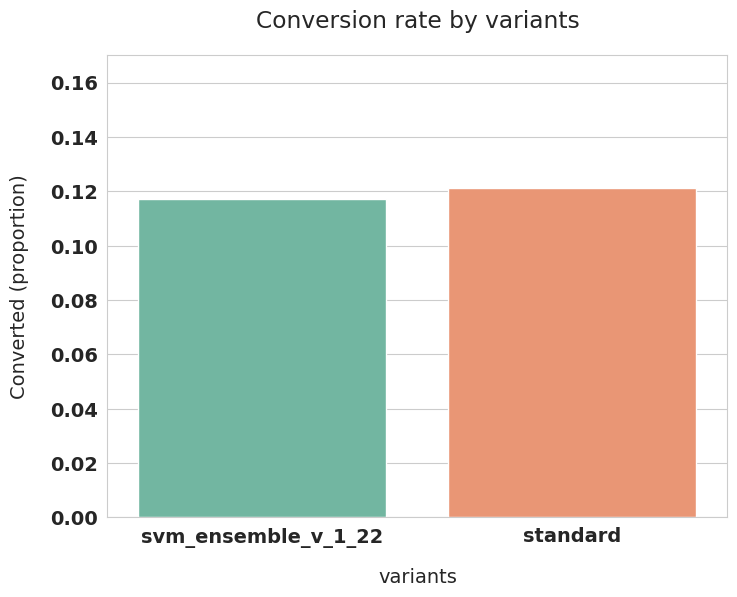

In [20]:
plt.rcParams['font.family'] = 'sans-serif'
# определим цвета.  сопоставим цвета с колонкой group в нашем df
unique_groups = df_new['variants'].unique()
colors = sns.color_palette("Set2", n_colors=len(unique_groups))  # выберем палитру и сопоставим с unique_groups

plt.figure(figsize=(8, 6))
sns.barplot(x='variants', y='converted', data=df_new, hue='variants', errorbar=('ci', False), palette=colors, legend=False) 
plt.ylim(0, 0.17)
plt.title('Conversion rate by variants', pad=20)
plt.xlabel('variants', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
plt.show()


### Тестирование гипотезы для группы new_user

In [21]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

standard = df_new[df_new['variants'] == 'standard']['converted']
svm_ensemble = df_new[df_new['variants'] == 'svm_ensemble_v_1_22']['converted']

n_standard = standard.count()
n_svm_ensemble = svm_ensemble.count()
successes = [standard.sum(), svm_ensemble.sum()]
nobs = [n_standard, n_svm_ensemble]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_new, lower_registered), (upper_new, upper_registered) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for standard: [{lower_new:.3f}, {upper_new:.3f}]')
print(f'CI 95% for svm_ensemble_v_1_22: [{lower_registered:.3f}, {upper_registered:.3f}]')

Z-statistic: 2.28
p-value: 0.023
CI 95% for standard: [0.119, 0.123]
CI 95% for svm_ensemble_v_1_22: [0.115, 0.120]


### Интерпретация результатов для группы new_user

Так как наше p-значение = 0.023 что ниже выбранной альфы 0.05, то согласно статистическому выводу, мы можем отклонить нулевую гипотезу H0, что означает что новый вариант работы svm_ensemble_v_1_22 статистически значимо влияет на уровень конверсии и повышение уровня конверсии в отношении новых пользоватлей.

Доверительный интервал для испытуемой группы [0.115, 0.120] или 11% и 12% соответственно:
1. Он не включает наш baseline в 13%
2. Он не достигает нашей цели 15%

Новый вариант работы svm_ensemble_v_1_22 статистически влияет на новых пользователей, однако не достигает нашей цели по увеличению конверсии на 2%.
Выбор:
1.Новый вариант работы влияет на новых пользователей, соответственно имеет смысл доработать svm_ensemble_v_1_22 и оценить опять;
2. Нам стоит оставить старый вариант работы, если доработка не окупается.

Оставить новый вариант работы для новых пользователей

## Тест группы registered_user 

In [22]:
# создадим df для группы registered_user
df_reg = df.loc[df['user_type'] == 'registered_user']
df_reg

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
...,...,...,...,...,...,...,...,...
294464,9c1f18e9-b20f-4ef2-ae8d-3a190c93e5c3,2022-05-17 01:51:56.106436,control,standard,0,United Kingdom,34-41,registered_user
294468,873f6fd0-8f8b-47c9-b38e-b18b65262430,2022-05-02 19:20:05.460595,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
294470,bd11ea90-58e6-4e15-b9b7-1e45bb83475a,2022-05-11 02:42:21.195145,control,standard,0,United Kingdom,34-41,registered_user
294475,d307b0ad-92a1-409c-a2d2-da8f4a118576,2022-05-22 11:45:03.439544,control,standard,0,United Kingdom,18-25,registered_user


In [23]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147240 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    147240 non-null  object
 1   timestamp  147240 non-null  object
 2   group      147240 non-null  object
 3   variants   147240 non-null  object
 4   converted  147240 non-null  int64 
 5   location   147240 non-null  object
 6   age_group  147240 non-null  object
 7   user_type  147240 non-null  object
dtypes: int64(1), object(7)
memory usage: 10.1+ MB


### Сбор данных и их подготовка для группы registered_user

In [24]:
# проверяем уникальность пользователей
sessions = df_reg['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [25]:
# проверяем количество пользователей без дубликтов
users_to_drop = sessions[sessions > 1].index
# Проверяем вхождения, знак ~ логическо нет
df_reg = df_reg[~df_reg['user_id'].isin(users_to_drop)]
print(f"Количество пользователей без дубликтов {df_reg.shape[0]}")

Количество пользователей без дубликтов 147240


In [26]:
# проверим на NaN строки
df_reg.isnull().sum()

user_id      0
timestamp    0
group        0
variants     0
converted    0
location     0
age_group    0
user_type    0
dtype: int64

In [27]:
# имеющиеся группы для A/B теста
df_reg.variants.unique()

array(['standard', 'svm_ensemble_v_1_22'], dtype=object)

In [28]:
# распределение вариантов работы для зарегистрированных пользователей 
df_reg.variants.value_counts()

variants
svm_ensemble_v_1_22    73798
standard               73442
Name: count, dtype: int64

In [29]:
# определяем долю уникальных значений относительно общего числа вхождений
df_reg.variants.value_counts(normalize=True)

variants
svm_ensemble_v_1_22    0.501209
standard               0.498791
Name: proportion, dtype: float64

### Визуализация результатов эксперимента для группы registered_user

In [30]:
# рассчитаем выборочные статистики, чтобы понять каково распределение данных и как выглядят наши выборки
conversion_rates = df_reg.groupby('variants')['converted']

# Стандартное отклонение для выборки
std_proportion = lambda x: np.std(x, ddof=0)

# Стандартная ошибка для выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

# уровень коверсии
conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
variants,,,
standard,0.119877,0.324818,0.001199
svm_ensemble_v_1_22,0.120450,0.325488,0.001198


Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя одинаково, в том числе выборочные средние коэффициенты конверсии ~11.98% для старого варианта работы против ~12.04% для нового варианта¶

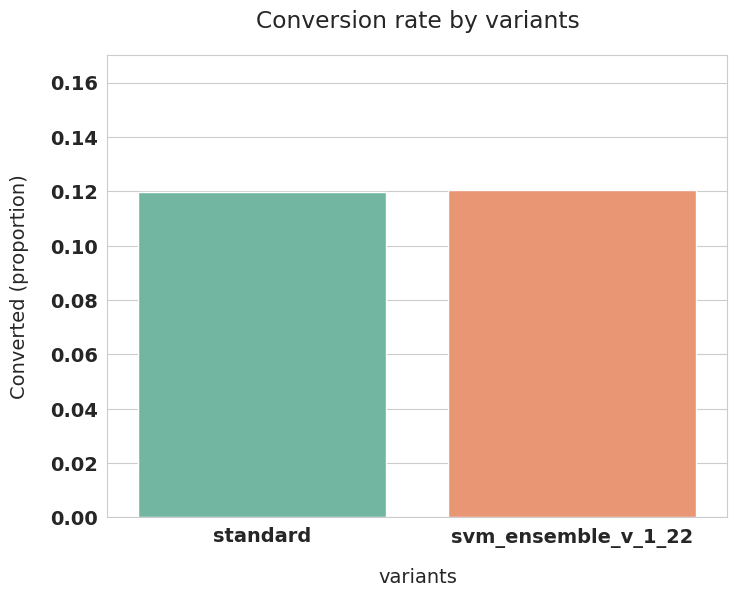

In [31]:
plt.rcParams['font.family'] = 'sans-serif'
# определим цвета.  сопоставим цвета с колонкой group в нашем df
unique_groups = df_reg['variants'].unique()
colors = sns.color_palette("Set2", n_colors=len(unique_groups))  # выберем палитру и сопоставим с unique_groups

plt.figure(figsize=(8, 6))
sns.barplot(x='variants', y='converted', data=df_reg, hue='variants', errorbar=('ci', False), palette=colors, legend=False) 
plt.ylim(0, 0.17)
plt.title('Conversion rate by variants', pad=20)
plt.xlabel('variants', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
plt.show()


### Тестирование гипотезы для группы registered_user

In [32]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

standard = df_reg[df_reg['variants'] == 'standard']['converted']
svm_ensemble = df_reg[df_reg['variants'] == 'svm_ensemble_v_1_22']['converted']

n_standard = standard.count()
n_svm_ensemble = svm_ensemble.count()
successes = [standard.sum(), svm_ensemble.sum()]
nobs = [n_standard, n_svm_ensemble]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_new, lower_registered), (upper_new, upper_registered) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for standard: [{lower_new:.3f}, {upper_new:.3f}]')
print(f'CI 95% for svm_ensemble_v_1_22: [{lower_registered:.3f}, {upper_registered:.3f}]')

Z-statistic: -0.34
p-value: 0.735
CI 95% for standard: [0.118, 0.122]
CI 95% for svm_ensemble_v_1_22: [0.118, 0.123]


### Интерпретация результатов для группы registered_user

Так как наше p-значение = 0.735 что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наш новый вариант работы svm_ensemble_v_1_22 никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии для зарегистрированных пользователей- это случайность.

Доверительный интервал для испытуемой группы [0.118, 0.123] или 11% и 12% соответственно:

1.Он не включает наш baseline
2.Он не достигает нашей цели 15%
Мы можем интерпретировать это как - наиболее вероятно, что реальный уровень конверсии сайта с новым вариантом работы  будет близок к baseline чем к 15%, который мы определили по нашей цели. Таким образом у нас два выбора:

1.Так как мы будем близко к baseline но его не достигает, то для зарегистрированных пользователей можно не оставлять новый вариант работы. 
2.Можно создать новую версию (потратить время, деньги, нервы) и опять протестировать, надо решать стоят ли затраты на новую версию 2% улучшения (покроются ли затраты на работу).

Ничего не менять для зарегистрированных пользователей.

# EDA по датасету

##### 1.Гистограмма (bar chart) для распределения пользователей по возрастным группам для всей выборки

In [33]:
# найдем распределение пользователей по возрастным группам
df.age_group.value_counts()


age_group
26-33    49270
50-57    49230
58+      49182
42-49    49119
34-41    48902
18-25    48775
Name: count, dtype: int64

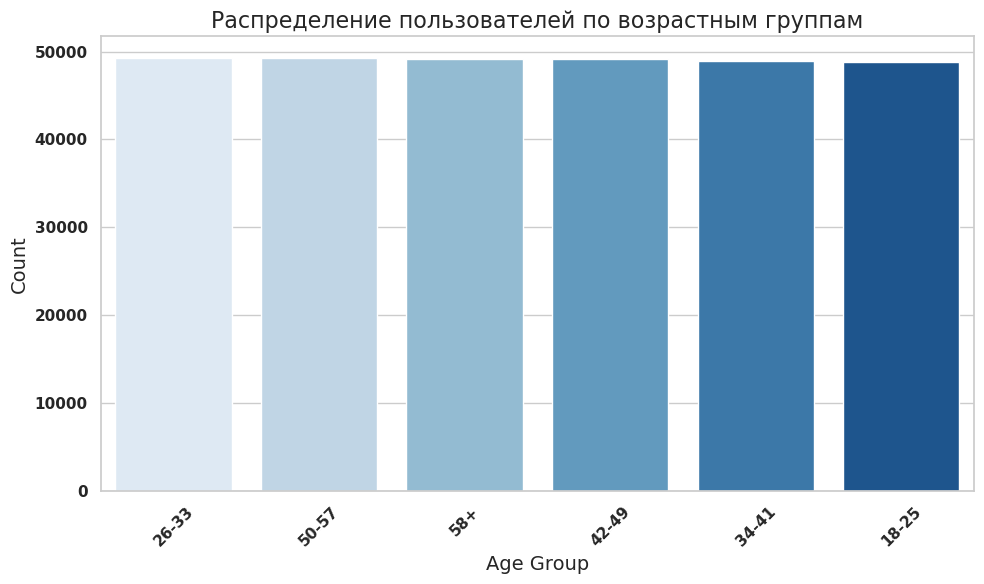

In [34]:
# построим гистограмму (bar chart) для распределения пользователей по возрастным группам
data_age = {
    'age_group': ['26-33', '50-57', '58+', '42-49', '34-41', '18-25'],
    'count': [49270, 49230, 49182, 49119, 48902, 48775]
}

# создадим DataFrame
df_age = pd.DataFrame(data_age)

# установим Seaborn стиль
sns.set(style='whitegrid')

# создадим гистограмму
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='count', hue='age_group', data=df_age, palette='Blues', legend=False)

# добавим названия
plt.title('Раcпределение пользователей по возрастным группам', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)

# вывод графика
plt.tight_layout()
plt.show()

##### 2. Графики зависимости плотности вероятности от значений среднего для старого и нового вариантов работы.

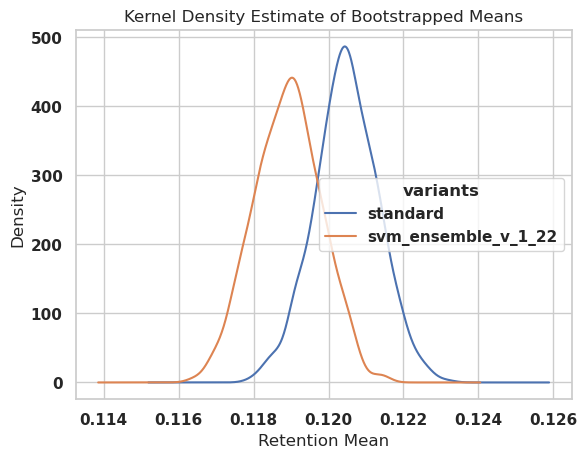

In [35]:
# выберем 100 итераций
iterations = 1000
boot_1d = []

# создадим список с бутстрепированными средними для каждой группы AB
for i in tqdm(range(iterations), leave=False):
    boot_mean = df.sample(frac=1, replace=True).groupby('variants').converted.mean()
    boot_1d.append(boot_mean)

# трансформируем список в DataFrame
boot_1d = pd.DataFrame(boot_1d)

# График оценки плотности ядра бутстрап-распределений
boot_1d.plot.kde()
plt.title('Kernel Density Estimate of Bootstrapped Means')
plt.xlabel('Retention Mean')
plt.ylabel('Density')
plt.show()

##### 3. График зависимости целевых обращений на сайте по датам

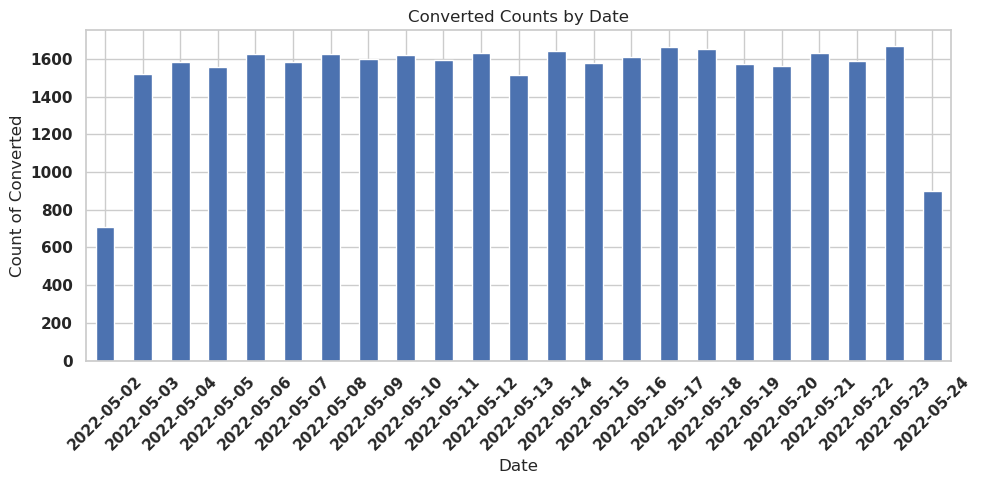

In [36]:
# преобразуем данные колнки 'timestamp' в формат datetime 
df['timestamp'] = pd.to_datetime(df['timestamp'])

# сгруппируем данные по 'timestamp' 
# группируем значения converted по сумме
df_grouped = df.groupby(df['timestamp'].dt.date)['converted'].sum()

# выводим результты в виде гистограммы
df_grouped.plot(kind='bar', figsize=(10, 5))
plt.title('Converted Counts by Date')
plt.xlabel('Date')
plt.ylabel('Count of Converted')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()